# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import Subset
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, roc_auc_score
from torch.nn import functional as F

In [2]:
SPLIT_SIZE = 5000
BATCH_SIZE = 64

I used as ID dataset Cifar10 and Cifar100 as OOD

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class to index mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


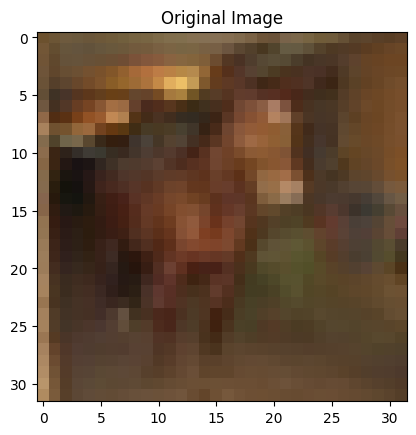

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7065024..1.7574502].


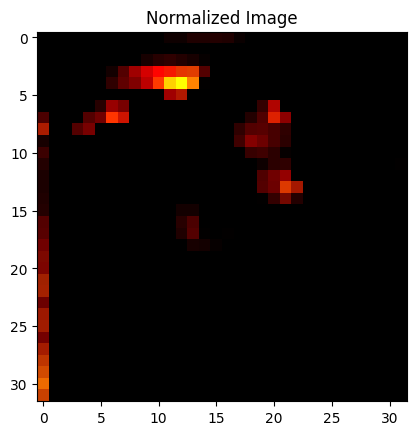

In [3]:
transform = transforms.ToTensor()
# Standard CIFAR10 transform.
id_mean = (0.4914, 0.4822, 0.4465)
id_std = (0.2470, 0.2435, 0.2616)
id_norm = transforms.Normalize(id_mean, id_std)

# Load CIFAR10 train and test.
id_ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
id_ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
id_classes = id_ds_train.classes
print(f'Classes: {id_classes}')
id_l2idx = id_ds_train.class_to_idx
print(f'Class to index mapping: {id_l2idx}')
id_idx2l = {v: k for k, v in id_l2idx.items()}
id_img_width = 32
id_img_height = 32

# Split train into train and validation.
I = np.random.permutation(len(id_ds_train))
id_ds_val = Subset(id_ds_train, I[:SPLIT_SIZE])
id_ds_train = Subset(id_ds_train, I[SPLIT_SIZE:])


# Example Plot
for x, _ in id_ds_train:
    plt.imshow(x.permute(1, 2, 0))
    plt.title(f'Original Image')
    plt.show()
    break


id_ds_train.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    id_norm
])
id_dl_train = torch.utils.data.DataLoader(id_ds_train, batch_size=BATCH_SIZE, shuffle=True)

id_ds_val.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    id_norm
])
id_dl_val = torch.utils.data.DataLoader(id_ds_val, batch_size=BATCH_SIZE, shuffle=False)

id_ds_test.transform = transforms.Compose([
    transforms.ToTensor(),
    id_norm
])
id_dl_test = torch.utils.data.DataLoader(id_ds_test, batch_size=BATCH_SIZE, shuffle=False)

for x, _ in id_ds_train:
    plt.imshow(x.permute(1, 2, 0))
    plt.title(f'Normalized Image')
    plt.show()
    break

Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'will

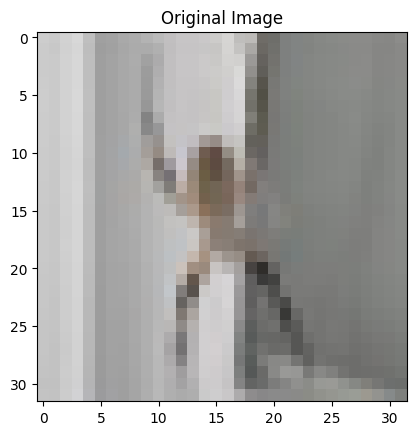

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2554682..1.5611241].


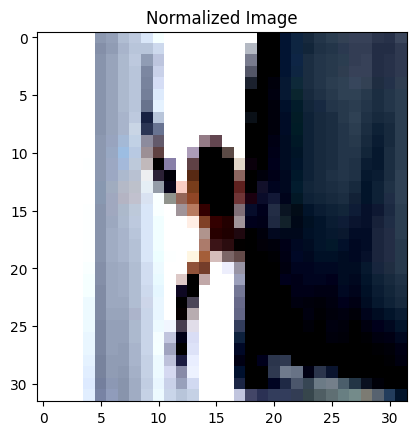

In [4]:
transform = transforms.ToTensor()
# Standard CIFAR10 transform.
ood_mean = (0.49139968, 0.48215841, 0.44653091)
ood_std = (0.24703223, 0.24348513, 0.26158784)
ood_norm = transforms.Normalize(ood_mean, ood_std)

# Load CIFAR100 train and test.
dataset_str = 'cifar10'
ood_ds_train = CIFAR100(root='./data', train=True, download=True, transform=transform)
ood_ds_test = CIFAR100(root='./data', train=False, download=True, transform=transform)
ood_classes = ood_ds_train.classes
print(f'Classes: {ood_classes}')
ood_l2idx = ood_ds_train.class_to_idx
print(f'Class to index mapping: {ood_l2idx}')
ood_img_width = 32
out_img_height = 32

# Split train into train and validation.
I = np.random.permutation(len(ood_ds_train))
ood_ds_val = Subset(ood_ds_train, I[:SPLIT_SIZE])
ood_ds_train = Subset(ood_ds_train, I[SPLIT_SIZE:])


# Example Plot
for x, _ in ood_ds_train:
    plt.imshow(x.permute(1, 2, 0))
    plt.title(f'Original Image')
    plt.show()
    break


ood_ds_train.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    ood_norm
])
ood_dl_train = torch.utils.data.DataLoader(ood_ds_train, batch_size=BATCH_SIZE, shuffle=True)

ood_ds_val.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    ood_norm
])
ood_dl_val = torch.utils.data.DataLoader(ood_ds_val, batch_size=BATCH_SIZE, shuffle=False)

ood_ds_test.transform = transforms.Compose([
    transforms.ToTensor(),
    ood_norm
])
ood_dl_test = torch.utils.data.DataLoader(ood_ds_test, batch_size=BATCH_SIZE, shuffle=False)

for x, _ in ood_ds_train:
    plt.imshow(x.permute(1, 2, 0))
    plt.title(f'Normalized Image')
    plt.show()
    break

In [5]:
print(f"Number of common classes: {sum(1 for c in id_classes if c in ood_classes)}")
print(f'Number of examples in ID test set: {len(id_ds_test)}, OOD test set: {len(ood_ds_test)}')

Number of common classes: 0
Number of examples in ID test set: 10000, OOD test set: 10000


There is no need to create a method to get images from the OOD dataset with classes different from the ID ones

In this lab we define a simple CNN because the statistics of predictions are out of scope

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.pool(x)
        x = self.activation(x)
        return x

class CNN(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(CNN, self).__init__()
        channels = [in_channels, 32, 64, 128]
        self.conv_block = nn.Sequential(*[ConvLayer(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),
            nn.Linear(channels[-1], num_classes),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.head(x)
        return x

In [6]:
model = CNN(num_classes=len(id_classes), in_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

x = torch.randn(1, 3, 32, 32).to(device)
print(f"Input shape: {x.shape}")
print(f"Output shape: {model(x).shape}")

Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 10])


In [6]:
def train(model, dl_train, dl_val, optimizer, criterion, epochs=10, device='cpu', log_interval=1, save_path='model.pth'):
    model.train()
    losses = {'train': [], 'val': []}
    accs = {'train': [], 'val': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = []

        model.train()
        for x, y in tqdm(dl_train):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            preds = output.argmax(dim=1)
            batch_acc = torch.mean((preds == y).float())
            epoch_acc.append(batch_acc.item())

        epoch_loss /= len(dl_train)
        losses['train'].append(epoch_loss)
        epoch_acc = np.mean(epoch_acc)
        accs['train'].append(epoch_acc)
        if epoch % log_interval == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            # Validation
            model.eval()
            val_loss = 0
            epoch_val_acc = []

            with torch.no_grad():
                for data, target in dl_val:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()
                    val_preds = output.argmax(dim=1)
                    batch_val_acc = torch.mean((val_preds == target).float())
                    epoch_val_acc.append(batch_val_acc.item())

                val_loss /= len(dl_val)
                val_accuracy = np.mean(epoch_val_acc)
            losses['val'].append(val_loss)
            accs['val'].append(val_accuracy)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')
    torch.save(model.state_dict(), save_path)

def evaluate(model, criterion, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    test_acc = []

    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            preds = output.argmax(dim=1)
            batch_acc = torch.mean((preds == target).float())
            test_acc.append(batch_acc.item())

    test_loss /= len(dl_test)
    test_accuracy = np.mean(test_acc)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, id_dl_train, id_dl_val, optimizer, criterion, epochs=10, device=device, log_interval=1)

In [ ]:
evaluate(model, criterion, id_dl_test, device=device)

Load if model already trained otherwise skip the cell

In [8]:
model = CNN(num_classes=len(id_classes), in_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load('id_model.pth'))

<All keys matched successfully>

In the cell below I defined a method to gather all the logits produced by a model on a given dataloader and another function to make an histogram plot to see how different the (max) logits distribution of the ID from the OOD one

In [9]:
def stack_logits(model, dl, device='cpu'):
    model.eval()
    all_logits = []

    with torch.no_grad():
        for data, _ in dl:
            data = data.to(device)
            output = model(data)
            all_logits.append(output.cpu().numpy())

    return np.vstack(all_logits)

def ood_test(model, id_dl_test, ood_dl_test, device='cpu'):
    id_logits = stack_logits(model, id_dl_test, device)
    ood_logits = stack_logits(model, ood_dl_test, device)
    plt.hist(id_logits.max(1), bins=100, density=True, alpha=0.5, label="ID")
    plt.hist(ood_logits.max(1), bins=100, density=True, alpha=0.5, label="OOD")
    plt.legend()

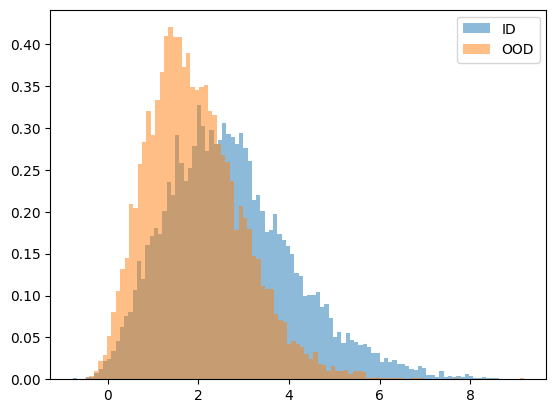

In [10]:
ood_test(model, id_dl_test, ood_dl_test, device=device)

As we can see now the two distributions are very overlapped, the model is confident about the predictions of out-of-distribution images, it cannot distinguish the fact that the images OOD come from a different distribution from the one has been trained on

# Exercise 1

Same as before but this time I gathered the predictions and plotted the ROC and PR curves

In [11]:
def stack_preds(model, id_dl_test, ood_dl_test, device='cpu'):
    id_logits = stack_logits(model, id_dl_test, device) #10k*10
    ood_logits = stack_logits(model, ood_dl_test, device) #10k*10
    all_logits = np.vstack([id_logits, ood_logits]) #20k*10
    all_probs = F.softmax(torch.tensor(all_logits), dim=1) #20k*10
    all_preds = np.max(all_probs.cpu().numpy(), axis=1) #20k

    return all_preds

def roc_pr_curve(all_preds, axes=None, eps=None):
    nexample = len(all_preds) // 2 #10k
    id_labels = np.ones(nexample) #10k
    ood_labels = np.zeros(nexample) #10k
    all_labels = np.hstack([id_labels, ood_labels]) #20k

    RocCurveDisplay.from_predictions(all_labels, all_preds, ax=axes[0], name=f"eps={eps}") if eps is not None else RocCurveDisplay.from_predictions(all_labels, all_preds, name='AUROC OOD Detection')
    axes[0].set_title(f"ROC Curves OOD Detection") if axes is not None else None

    PrecisionRecallDisplay.from_predictions(all_labels, all_preds, ax=axes[1], name=f"eps={eps}") if eps is not None else PrecisionRecallDisplay.from_predictions(all_labels, all_preds, name='AUPR ID Positive')
    axes[1].set_title(f"PR Curves ID Positive") if axes is not None else None

    id_labels_zeros = np.zeros(nexample) #10k
    ood_labels_ones = np.ones(nexample) #10k
    all_labels = np.hstack([id_labels_zeros, ood_labels_ones]) #20k

    PrecisionRecallDisplay.from_predictions(all_labels, all_preds, ax=axes[2], name=f"eps={eps} OOD Positive") if eps is not None else PrecisionRecallDisplay.from_predictions(all_labels, all_preds, name='AUPR OOD Positive')  
    axes[2].set_title(f"PR Curves OOD Positive") if axes is not None else None



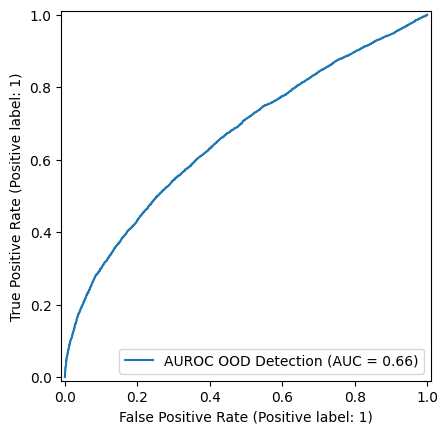

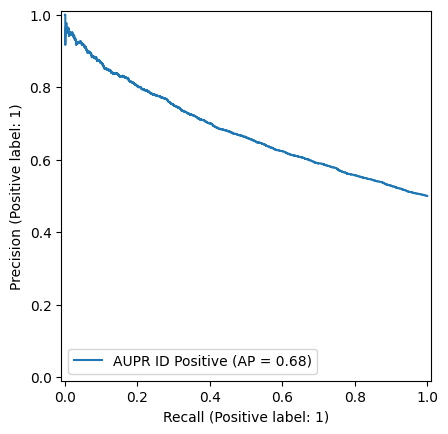

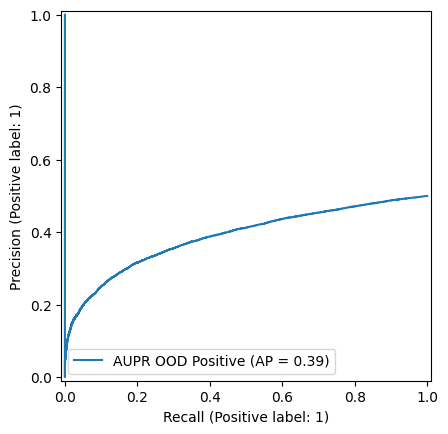

In [12]:
all_preds = stack_preds(model, id_dl_test, ood_dl_test, device=device)

roc_pr_curve(all_preds)

# Exercise 2

For the implementation of the FGSM there are two details to notice: first I clampled the data to avoid out of bounds values, second the perturbation has been applied to the example only after the remotion of the normalization

In [13]:
def fgsm_attack(data, eps, grad):
    data_perturbed = data + eps * grad.sign()
    data_perturbed = torch.clamp(data_perturbed, 0, 1)  # Ensure pixel values are in [0, 1]
    return data_perturbed

def remove_normalization(data, mean, std):
    transform = transforms.Normalize(mean=[-i for i in mean], std=[1/i for i in std])
    return transform(data)
 
def test_attack(model, criterion, dl_test, eps, mean, std, save_adv=5, device='cpu'):
    model.eval()
    correct = {'classical': 0, 'adversarial': 0}
    total = 0
    adv_list = {'preds': [], 'labels': [], 'adv_images': []}
    logits_id = []
    logits_ood = []

    for x, y in dl_test:    
        x, y = x.to(device), y.to(device)
        x.requires_grad = True
        model.zero_grad()
        output = model(x)
        logits_id.append(output.detach().cpu().numpy())
        preds = torch.argmax(output, dim=1)
        loss = criterion(output, y)
        loss.backward()
        total += y.size(0)
        correct['classical'] += (preds == y).sum().item()

        grad = x.grad.data
        x_perturbed = remove_normalization(x, mean, std)
        x_perturbed = fgsm_attack(x_perturbed, eps, grad)
        x_perturbed_norm = transforms.Normalize(mean, std)(x_perturbed)
        output_perturbed = model(x_perturbed_norm)
        logits_ood.append(output_perturbed.detach().cpu().numpy())
        preds_perturbed = torch.argmax(output_perturbed, dim=1)
        if save_adv > 0 and len(adv_list['labels']) < save_adv:
            # Save adversarial one example for each batch
            adv_list['labels'].append(y[0].detach().cpu().numpy())
            adv_list['preds'].append(preds_perturbed[0].detach().cpu().numpy())
            adv_list['adv_images'].append(x_perturbed[0].detach().cpu().numpy())
        correct['adversarial'] += (preds_perturbed == y).sum().item()

    accuracies = {key: val / total for key, val in correct.items()}
    print(f'Accuracy of the model on the test set: {accuracies["classical"]:.2f}% (classical), {accuracies["adversarial"]:.2f}% (adversarial)')
    return logits_id, logits_ood, adv_list

Here there is a pipeline to test the effect of the perturbation on the accuracy before and after the perturbation

In [14]:
eps_list = [0.01, 0.05, 0.1, 0.5, 1]
criterion = nn.CrossEntropyLoss()
adv_results = []
logits_id = []
logits_ood = []
for eps in eps_list:
    print(f'Testing FGSM attack with epsilon: {eps}')
    eps_logits_id, eps_logits_ood, eps_adv_list = test_attack(model, criterion, id_dl_test, eps=eps, mean=id_mean, std=id_std, save_adv=5, device=device)
    adv_results.append(eps_adv_list)
    logits_id.append(eps_logits_id)
    logits_ood.append(eps_logits_ood)

Testing FGSM attack with epsilon: 0.01
Accuracy of the model on the test set: 0.64% (classical), 0.22% (adversarial)
Testing FGSM attack with epsilon: 0.05
Accuracy of the model on the test set: 0.64% (classical), 0.05% (adversarial)
Testing FGSM attack with epsilon: 0.1
Accuracy of the model on the test set: 0.64% (classical), 0.04% (adversarial)
Testing FGSM attack with epsilon: 0.5
Accuracy of the model on the test set: 0.64% (classical), 0.10% (adversarial)
Testing FGSM attack with epsilon: 1
Accuracy of the model on the test set: 0.64% (classical), 0.10% (adversarial)


Now we try to consider the stack of FGSM-perturbed images as OOD dataset, to make the same analysis as before 

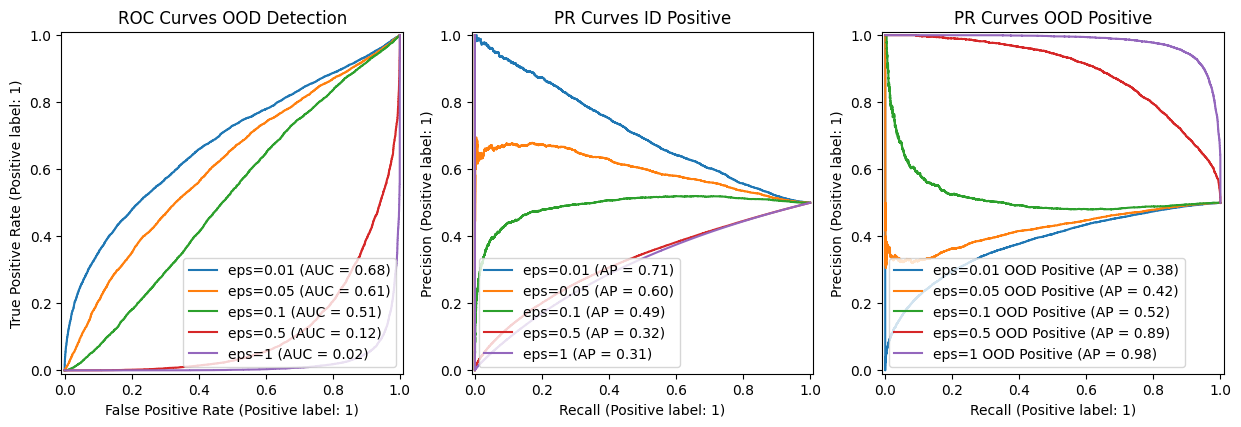

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
logits_id = [np.vstack(logits_id[i]) for i in range(len(logits_id))]
logits_ood = [np.vstack(logits_ood[i]) for i in range(len(logits_ood))]
all_logits = np.hstack([logits_id, logits_ood])  # Stack all logits
for i, eps in enumerate(eps_list): 
    all_preds = np.max(F.softmax(torch.tensor(all_logits[i]), dim=1).cpu().numpy(), axis=1)  # Get max logits for each epsilon
    roc_pr_curve(all_preds, axes=axes, eps=eps)


The AUC it is built according to True Positives (TP) and False Positives (FP), is a measure that quantify the probabilities that given a positive and a negative example, the prediction goes for the positive, for example in the binary classification example (“1” vs. “0”), the AUROC tells you the probability that a randomly selected “1” image will have a higher predicted probability of being a “1” than a randomly selected “0” image.

In our scenario I gathered all the logits, and got the probs for each classes then I took out the maximum one for each sample, as expected the AUC become worse with the growth of epsilon.

The PR curve is a graphical measure of tradeoff between precision (the ability of performing correct prediction) and recall (the ability to assess a lot of predictions), where precision relates to a low false positive rate, and recall relates to a low false negative rate.

Having both with high values implies that the classifier returns accuration and recognition as well.

To get a scalr measure it is necessary to get the Average Precision (a weighted average summarizing the plot)

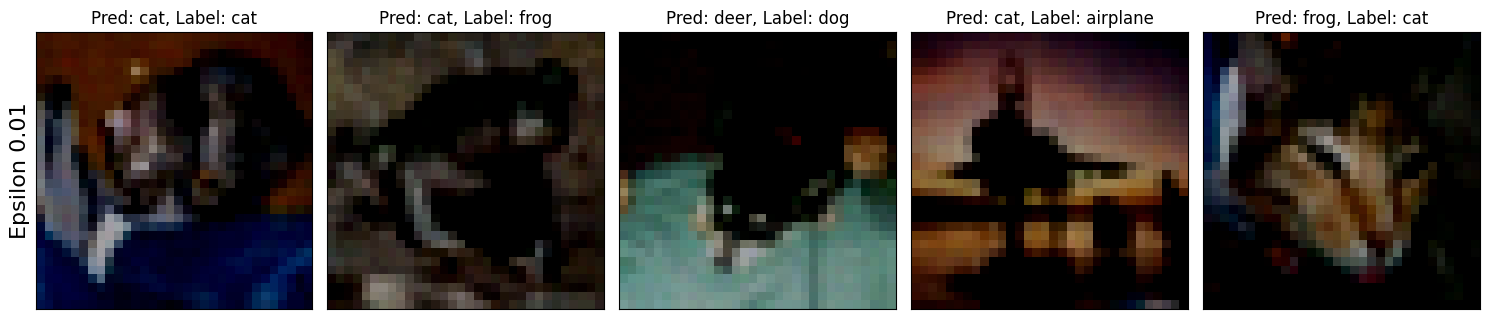

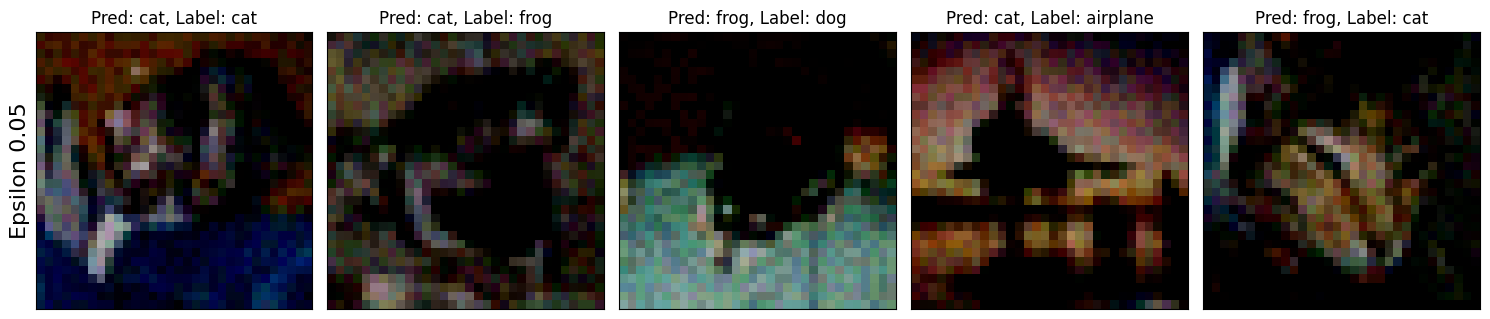

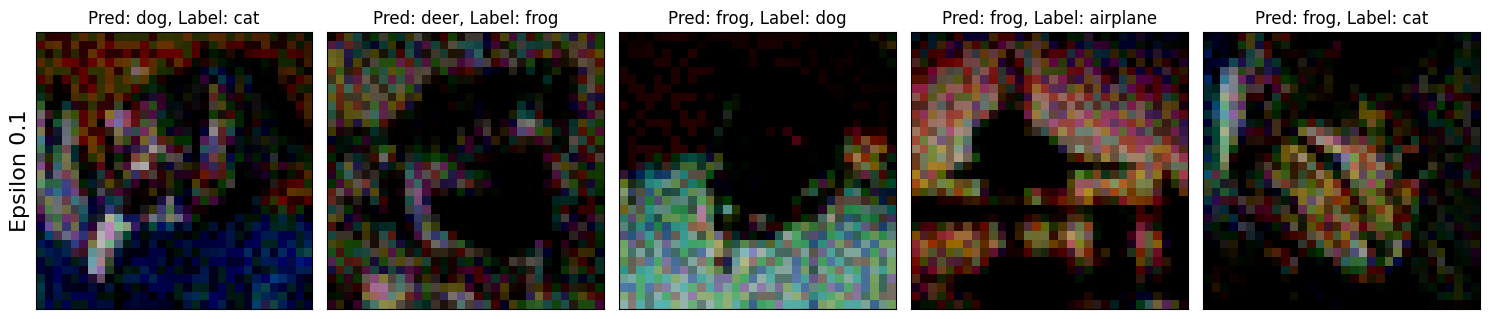

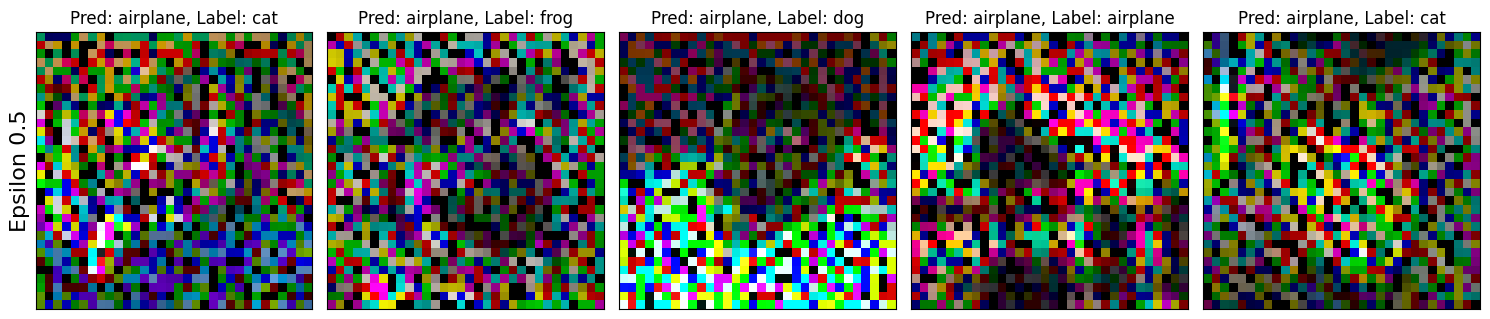

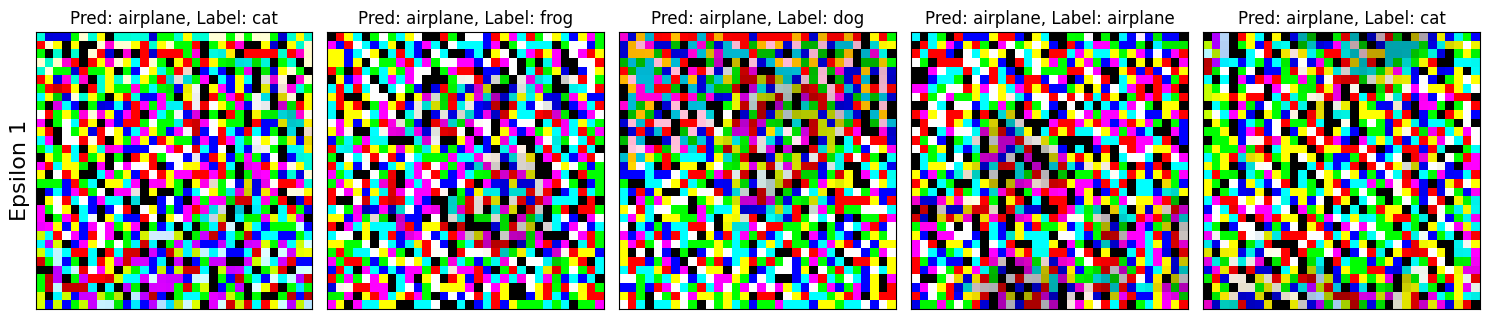

In [16]:
# Show some adversarial images
k=1
for i, eps in enumerate(eps_list):
    plt.figure(figsize=(15, 20))
    for j in range(len(adv_results[i]['adv_images'])):
        plt.subplot(len(eps_list), len(adv_results[i]['adv_images']), k)
        plt.imshow(adv_results[i]['adv_images'][j].transpose(1, 2, 0))
        plt.xticks([], [])
        plt.yticks([], [])
        if j ==0:
            plt.ylabel(f'Epsilon {eps}', fontsize=16)
        class_pred = id_idx2l[adv_results[i]['preds'][j].item()]
        class_label = id_idx2l[adv_results[i]['labels'][j].item()]
        plt.title(f'Pred: {class_pred}, Label: {class_label}')
        k+=1
    plt.tight_layout()
    plt.show()

It is interesting the fact that more chaotic the image become, higher is the probability that the sample will be predicted as an Airplane, mayde due to the high complexity of the object the model has not been able to capture the necessary features to assess the correct prediction

The following class create a dataset composed of the FGSM-perturbed example, the stack_original parameter is used to choose wether to make augmentation of the base dataset or get only the perturbed data

In [17]:
class FGSMDataset(torch.utils.data.Dataset):
    def __init__(self, dl_train, model, eps, mean, std, device='cpu', stack_original=False):
        self.eps = eps
        self.mean = mean
        self.std = std
        self.device = device
        model.eval()
        adv_images = []
        adv_labels = []
        model.eval()
        for x, y in tqdm(dl_train):
            x, y = x.to(device), y.to(device)
            x.requires_grad = True
            model.zero_grad()
            output = model(x)
            loss = nn.CrossEntropyLoss()(output, y)
            loss.backward()
            grad = x.grad.data
            x_perturbed = remove_normalization(x, mean, std)
            x_perturbed = fgsm_attack(x_perturbed, eps, grad)
            x_perturbed_norm = transforms.Normalize(mean, std)(x_perturbed)
            
            adv_images.append(x_perturbed_norm.detach().cpu().numpy())
            adv_images.append(x.detach().cpu().numpy()) if stack_original else None
            adv_labels.append(y.detach().cpu().numpy()) 
            adv_labels.append(y.detach().cpu().numpy())
        self.images = np.vstack(adv_images)
        self.labels = np.hstack(adv_labels)
        print(f'Created FGSMDataset with {len(self.images)} total examples.')

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [18]:
eps = 0.1
fgsm_dataset = FGSMDataset(id_dl_train, model, eps=eps, mean=id_mean, std=id_std, device=device, stack_original=True)
model.to('cpu')
fgsm_dl_train = torch.utils.data.DataLoader(fgsm_dataset, batch_size=BATCH_SIZE, shuffle=True)



# Train the model on adversarial examples or load model
model_aug = CNN(num_classes=len(id_classes), in_channels=3)
model_aug.to(device)
#optimizer = torch.optim.Adam(model_aug.parameters(), lr=1e-4)
#train(model_aug, fgsm_dl_train, id_dl_val, optimizer, criterion, epochs=10, device=device, log_interval=1, save_path='model_aug.pth')

model_aug.load_state_dict(torch.load('model_aug.pth'))

100%|██████████| 704/704 [00:10<00:00, 67.03it/s]


Created FGSMDataset with 90000 total examples.


<All keys matched successfully>

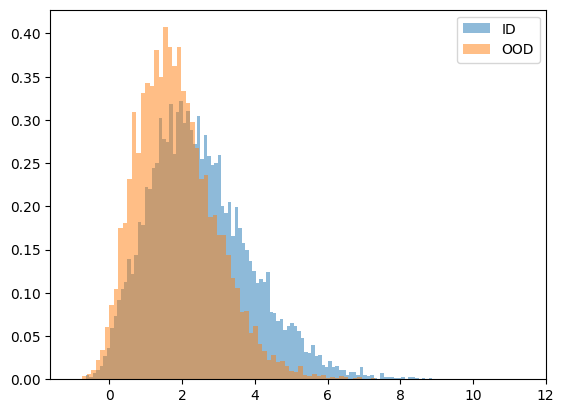

In [19]:
ood_test(model_aug, id_dl_test, ood_dl_test, device=device)

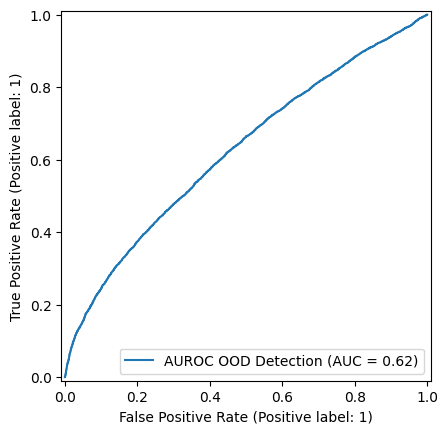

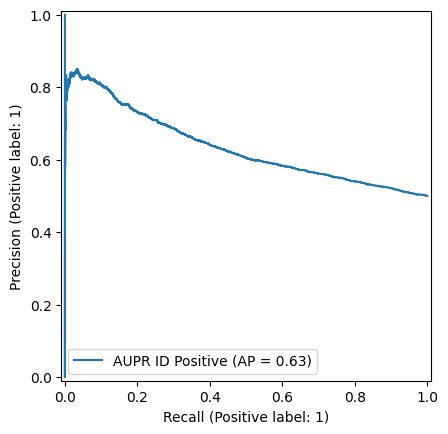

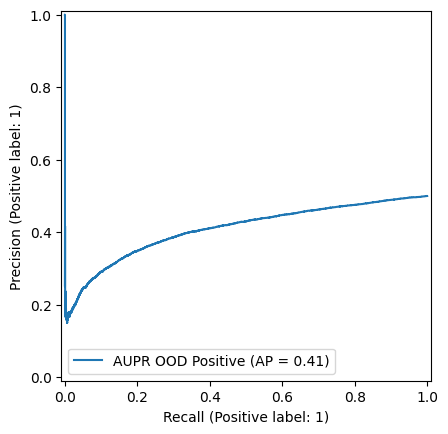

In [20]:
all_preds_aug = stack_preds(model_aug, id_dl_test, ood_dl_test, device=device)

roc_pr_curve(all_preds_aug)

# Exercise 3.1

Now I implemented ODIN, a more structured idea but similar to what we have just done.

There is a temperature T parameter scaling the softmax, the usual noise magnitude parameter epsilon and a final parameter delta used as decision threshold

First we load the vanilla model used until now

In [21]:
# Load Model
model = CNN(num_classes=len(id_classes), in_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
model.to(device)
model.load_state_dict(torch.load('id_model.pth'))

<All keys matched successfully>

Usual perturbation definition

In [25]:
def x_perturbation(x, mean, std, eps):
    x_grad = torch.log(x.grad)
    x_pert = remove_normalization(x, mean, std) - eps * (-x_grad).sign()
    x_pert = torch.clamp(x_pert, 0, 1)  # Ensure pixel values are in [0, 1]
    x_pert = transforms.Normalize(mean, std)(x_pert)
    return x_pert

The odin_score function is very similar to the attack fgsm one, there is a perturbation grad-dependant, the only slight difference is the loss function which now takes into account the temperature scaling T

In [23]:
def odin_score(model, dl_test, eps, T, mean, std, device='cpu'):
    model.eval()
    max_probs = []
    logits = []
    probs = []
    for x, y in tqdm(dl_test):
        x, y = x.to(device), y.to(device)
        x.requires_grad = True
        model.zero_grad()
        output = model(x)
        soft_scores = torch.softmax(output / T, dim=1)
        max_idx = torch.argmax(soft_scores, dim=1)
        # Following the idea of EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES the loss is computed
        # according to the kind of perturbation we want in the adversarial example
        # in this case the maximum softmax probability is used
        loss = F.cross_entropy(output / T, max_idx)
        loss.backward()
        
        x_perturbed = x_perturbation(x, mean, std, eps)
        output_perturbed = model(x_perturbed)
        logits.append(output_perturbed.detach().cpu().numpy())

        probs_perturbed = torch.softmax(output_perturbed / T, dim=1)
        max_prob, _ = probs_perturbed.max(dim=1)
        probs.append(probs_perturbed.detach().cpu().numpy())
        max_probs.append(max_prob.detach().cpu().numpy())
    return logits, probs, max_probs

Given T and eps we can gather the corresponding logits, probabilities and max probabilities tensors

Once got these infromations we can obtain the delta, choosing the recall_threshold value (in the paper 0.95 is used)

In [26]:
T = 1000
eps = 0.1
logits_id, probs_id, max_id = odin_score(model, id_dl_test, eps=0.1, T=T, mean=id_mean, std=id_std, device=device)
logits_ood, probs_ood, max_ood = odin_score(model, ood_dl_test, eps=0.1, T=T, mean=id_mean, std=id_std, device=device)

100%|██████████| 157/157 [00:04<00:00, 35.52it/s]


In [27]:
def odin_detector(scores, recall_threshold=0.95):
    id_scores = scores['id']
    ood_scores = scores['ood']
    all_scores = np.hstack([id_scores, ood_scores])

    labels_id = np.ones(len(id_scores))
    labels_ood = np.zeros(len(ood_scores))
    all_labels = np.hstack([labels_id, labels_ood])

    precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)
    min_recall = np.argmin(recall >= recall_threshold)
    delta = thresholds[min_recall]
    return all_scores > delta, delta

In [28]:
scores = {
    'id': np.hstack(max_id),
    'ood': np.hstack(max_ood)
}
g, delta = odin_detector(scores)
print(f"Threshold for OOD detection: {delta:.4f}")
print(f"Number of example detected as ID: {np.sum(g[:len(max_id)])}")

Threshold for OOD detection: 0.1002
Number of example detected as ID: 150


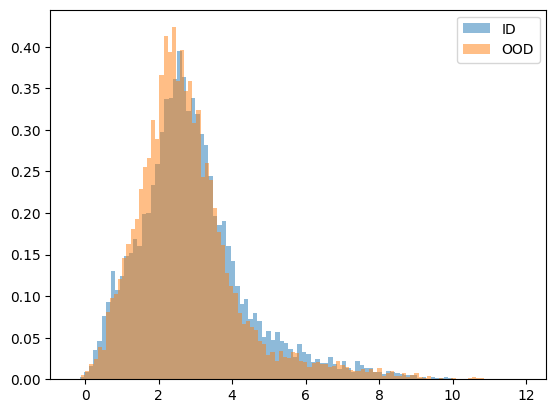

In [29]:
_ = plt.hist(np.vstack(logits_id).max(1), bins=100, density=True, alpha=0.5, label="ID")
_ = plt.hist(np.vstack(logits_ood).max(1), bins=100, density=True, alpha=0.5, label="OOD")
plt.legend()

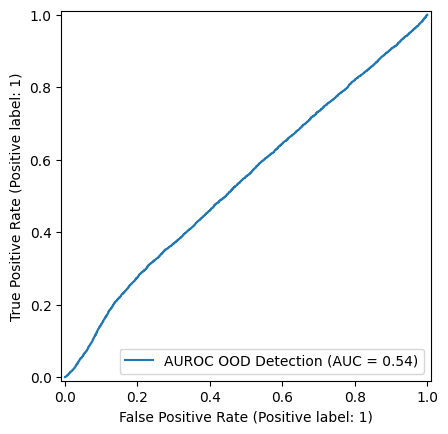

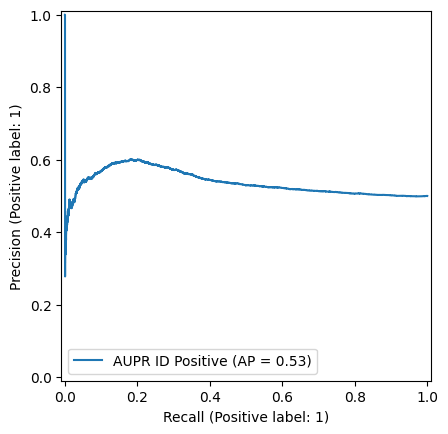

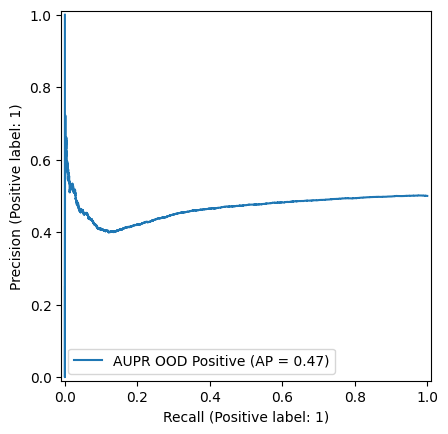

In [31]:
logits_id = np.vstack(logits_id) #10k*10
logits_ood = np.vstack(logits_ood) #10k*10
all_logits = np.vstack([logits_id, logits_ood]) #20k*10
all_preds = np.max(F.softmax(torch.tensor(all_logits), 1).cpu().numpy(), axis=1) #20k
roc_pr_curve(all_preds)

Sadly there is still no gain in recognition between ID and OOD using the technique.

But I used random parameter, a smarter idea is to perform a grid search

In [38]:
# Grid search for optimality

labels_id = np.array([0 for _ in range(len(id_ds_test))])
labels_ood = np.array([1 for _ in range(len(ood_ds_test))])
all_labels = np.hstack([labels_id, labels_ood]) #20k

opt_roc = -float("inf")
opt_params = None

for T in np.linspace(1000, 10000, 5):
    for eps in np.linspace(0.01, 0.1, 5):
        logits_id, probs_id, max_id = odin_score(model, id_dl_test, eps=eps, T=T, mean=id_mean, std=id_std, device=device)
        logits_ood, probs_ood, max_ood = odin_score(model, ood_dl_test, eps=eps, T=T, mean=id_mean, std=id_std, device=device)
        scores = np.hstack([np.hstack(max_id), np.hstack(max_ood)])
        roc = roc_auc_score(all_labels, scores)
        print(f"T: {T:.1f} | eps: {eps:.5f} | roc: {roc:.3f}")

        if roc > opt_roc:
            opt_roc = roc
            opt_params = [T, eps]

print(f"Optimal parameters: T={opt_params[0]:.1f}, eps={opt_params[1]:.5f} with ROC AUC: {opt_roc:.3f}")
torch.save(opt_params, 'odin_opt_params.pth')

100%|██████████| 157/157 [00:04<00:00, 36.27it/s]


T: 1000.0 | eps: 0.01000 | roc: 0.443


100%|██████████| 157/157 [00:04<00:00, 36.27it/s]


T: 1000.0 | eps: 0.03250 | roc: 0.444


100%|██████████| 157/157 [00:04<00:00, 36.41it/s]


T: 1000.0 | eps: 0.05500 | roc: 0.450


100%|██████████| 157/157 [00:04<00:00, 36.21it/s]


T: 1000.0 | eps: 0.07750 | roc: 0.457


100%|██████████| 157/157 [00:04<00:00, 36.26it/s]


T: 1000.0 | eps: 0.10000 | roc: 0.463


100%|██████████| 157/157 [00:04<00:00, 36.46it/s]


T: 3250.0 | eps: 0.01000 | roc: 0.443


100%|██████████| 157/157 [00:04<00:00, 36.55it/s]


T: 3250.0 | eps: 0.03250 | roc: 0.444


100%|██████████| 157/157 [00:04<00:00, 36.44it/s]


T: 3250.0 | eps: 0.05500 | roc: 0.450


100%|██████████| 157/157 [00:04<00:00, 36.35it/s]


T: 3250.0 | eps: 0.07750 | roc: 0.457


100%|██████████| 157/157 [00:04<00:00, 36.95it/s]


T: 3250.0 | eps: 0.10000 | roc: 0.463


100%|██████████| 157/157 [00:04<00:00, 38.08it/s]


T: 5500.0 | eps: 0.01000 | roc: 0.443


100%|██████████| 157/157 [00:04<00:00, 36.94it/s]


T: 5500.0 | eps: 0.03250 | roc: 0.444


100%|██████████| 157/157 [00:04<00:00, 36.51it/s]


T: 5500.0 | eps: 0.05500 | roc: 0.450


100%|██████████| 157/157 [00:04<00:00, 36.34it/s]


T: 5500.0 | eps: 0.07750 | roc: 0.457


100%|██████████| 157/157 [00:04<00:00, 35.90it/s]


T: 5500.0 | eps: 0.10000 | roc: 0.463


100%|██████████| 157/157 [00:04<00:00, 36.18it/s]


T: 7750.0 | eps: 0.01000 | roc: 0.443


100%|██████████| 157/157 [00:04<00:00, 37.92it/s]


T: 7750.0 | eps: 0.03250 | roc: 0.444


100%|██████████| 157/157 [00:04<00:00, 38.08it/s]


T: 7750.0 | eps: 0.05500 | roc: 0.450


100%|██████████| 157/157 [00:04<00:00, 38.24it/s]


T: 7750.0 | eps: 0.07750 | roc: 0.457


100%|██████████| 157/157 [00:04<00:00, 37.83it/s]


T: 7750.0 | eps: 0.10000 | roc: 0.463


100%|██████████| 157/157 [00:04<00:00, 36.75it/s]


T: 10000.0 | eps: 0.01000 | roc: 0.443


100%|██████████| 157/157 [00:04<00:00, 36.30it/s]


T: 10000.0 | eps: 0.03250 | roc: 0.444


100%|██████████| 157/157 [00:04<00:00, 36.10it/s]


T: 10000.0 | eps: 0.05500 | roc: 0.450


100%|██████████| 157/157 [00:04<00:00, 36.31it/s]


T: 10000.0 | eps: 0.07750 | roc: 0.457


100%|██████████| 157/157 [00:04<00:00, 38.31it/s]

T: 10000.0 | eps: 0.10000 | roc: 0.463
Optimal parameters: T=7750.0, eps=0.10000 with ROC AUC: 0.463


In [41]:
opt_params = torch.load('odin_opt_params.pth', weights_only=False)

100%|██████████| 157/157 [00:04<00:00, 38.34it/s]


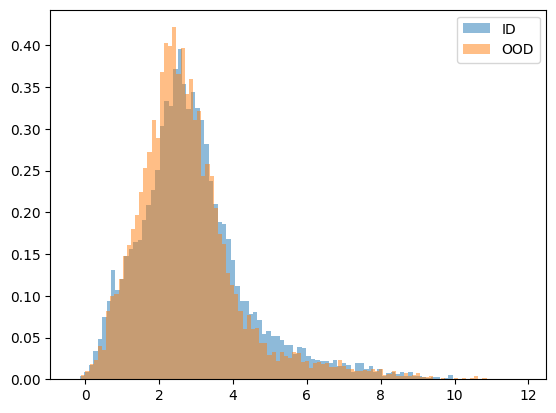

In [42]:
T = opt_params[0]
eps = opt_params[1]
logits_id, probs_id, max_id = odin_score(model, id_dl_test, eps=eps, T=T, mean=id_mean, std=id_std, device=device)
logits_ood, probs_ood, max_ood = odin_score(model, ood_dl_test, eps=eps, T=T, mean=id_mean, std=id_std, device=device)
_ = plt.hist(np.vstack(logits_id).max(1), bins=100, density=True, alpha=0.5, label="ID")
_ = plt.hist(np.vstack(logits_ood).max(1), bins=100, density=True, alpha=0.5, label="OOD")
plt.legend()

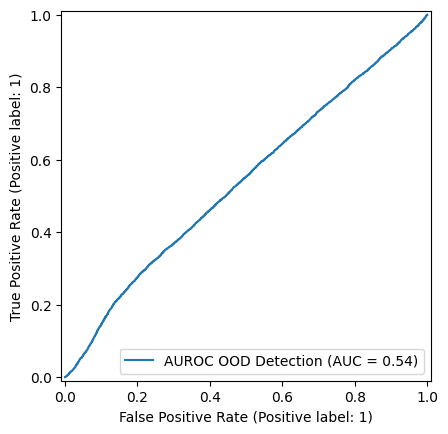

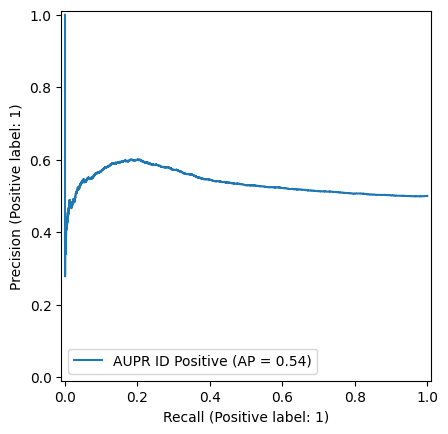

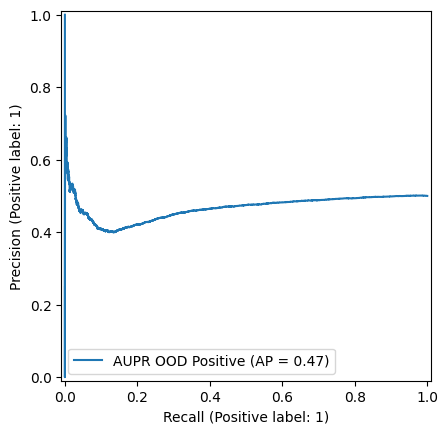

In [43]:
logits_id = np.vstack(logits_id) #10k*10
logits_ood = np.vstack(logits_ood) #10k*10
all_logits = np.vstack([logits_id, logits_ood]) #20k*10
all_preds = np.max(F.softmax(torch.tensor(all_logits), 1).cpu().numpy(), axis=1) #20k
roc_pr_curve(all_preds)

While the AUROC seems to uneffected by the ODIN there some kind of leveling on the Precision-Recall, which now display a constant-like shape with a worse AP

# Exercise 3.2

The idea behind JARN has some ideas in common with GAN, there are three main components: a Generator (the network used until now), and Adaptor (a small network with the sole purpose of project the Jacobian onto the image domain) and the Discriminator (a network with the role of distinguish real example)

Exactly like in the GAN setting there is an adversarial-like training in which the Generator and the Discriminator are in competition, so the training may be more complex and less stable

In [11]:
model = CNN(num_classes=len(id_classes), in_channels=3)
model.load_state_dict(torch.load('id_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
model.to(device)

CNN(
  (conv_block): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (activation): ReLU()
    )
    (1): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (activation): ReLU()
    )
    (2): ConvLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (activation): ReLU()
    )
  )
  (head): Sequential

In [13]:
eps = 0.1
train_perturbed = FGSMDataset(id_dl_train, model, eps=eps, mean=id_mean, std=id_std, device=device)
fgsm_dl_train = torch.utils.data.DataLoader(train_perturbed, batch_size=BATCH_SIZE, shuffle=True)

test_perturbed = FGSMDataset(id_dl_test, model, eps=eps, mean=id_mean, std=id_std, device=device, stack_original=True)
fgsm_dl_test = torch.utils.data.DataLoader(test_perturbed, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 704/704 [00:16<00:00, 43.38it/s]


Created FGSMDataset with 45000 total examples.


100%|██████████| 157/157 [00:03<00:00, 44.15it/s]


Created FGSMDataset with 20000 total examples.


In [44]:
class Adaptor(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=1)
        self.activation = nn.Tanh()

    def forward(self, x):
        return self.activation(self.conv(x))

class Discriminator(nn.Module):
    def __init__(self, channels=[32, 64, 128, 256, 512]):
        super().__init__()
        self.conv_block = nn.Sequential(*[ConvLayer(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        self.head = nn.Sequential(nn.Conv2d(channels[-1], 1, kernel_size=1),
                                  nn.AdaptiveAvgPool2d((1, 1)),
                                  nn.Flatten(),
                                  nn.Sigmoid())

    def forward(self, x):
        x = self.conv_block(x)
        x = self.head(x)
        return x
    
class Generator(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super().__init__()
        self.cnn = CNN(num_classes=num_classes, in_channels=in_channels)

    def forward(self, x):
        logits = self.cnn(x)
        return logits

In [ ]:
def adv_train(models, dl_train, optimizers, lambda_adv=1, epochs=10, device='cpu', log_interval=1):

    for model in models.keys():
        models[model].to(device)
        models[model].train()

    for epoch in range(epochs):
        acc = 0
        for x, y in tqdm(dl_train):
            x, y = x.to(device), y.to(device)
            x.requires_grad = True
            for opt in optimizers.keys():
                optimizers[opt].zero_grad()

            # Forward pass through generator
            logits = models['generator'](x)
            loss_cls = F.cross_entropy(logits, y)
            loss_cls.backward(retain_graph=True)
            preds = torch.argmax(logits, dim=1)
            acc += torch.mean((preds == y).float()).item()

            J = x.grad.data
            J_apt = models['adaptor'](J)

            # Forward pass through discriminator
            D_real = models['discriminator'](x)
            D_fake = models['discriminator'](J_apt)

            # Compute losses and Backward pass
            loss_adv = (torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8)).mean()
            loss_adv.backward(retain_graph=True)

            loss_total = loss_cls + lambda_adv*loss_adv
            loss_total.backward(retain_graph=True)

            for opt in optimizers.keys():
                optimizers[opt].step()

        if epoch % log_interval == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Loss Total: {loss_total.item()/len(dl_train):.4f}, Loss Cls: {loss_cls.item()/len(dl_train):.4f}, Loss Adv: {loss_adv.item()/len(dl_train):.4f}')
            print(f'Accuracy: {acc/len(dl_train):.4f}')
    for model in models.keys():
        torch.save(models[model].state_dict(), f'{model}.pth')

In [22]:
model_gen = Generator(num_classes=len(id_classes), in_channels=3)
model_apt = Adaptor(channels=3)
model_disc = Discriminator(channels=[3, 32, 64, 128, 256, 512])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
optimizer_gen = torch.optim.Adam(model_gen.parameters(), lr=1e-4)
optimizer_apt = torch.optim.Adam(model_apt.parameters(), lr=1e-4)
optimizer_disc = torch.optim.Adam(model_disc.parameters(), lr=1e-4)

models = {
    'generator': model_gen,
    'adaptor': model_apt,
    'discriminator': model_disc
}
optimizers = {
    'generator': optimizer_gen,
    'adaptor': optimizer_apt,
    'discriminator': optimizer_disc
}
# Train the adversarial model
adv_train(models, fgsm_dl_train, optimizers, lambda_adv=1, epochs=10, device=device)

  0%|          | 0/704 [00:00<?, ?it/s]

100%|██████████| 704/704 [01:10<00:00, 10.04it/s]


Epoch: 1/10, Loss Total: -0.0488, Loss Cls: 0.0034, Loss Adv: -0.0522
Accuracy: 0.0985


100%|██████████| 704/704 [01:09<00:00, 10.16it/s]


Epoch: 2/10, Loss Total: -0.0488, Loss Cls: 0.0034, Loss Adv: -0.0522
Accuracy: 0.1114


100%|██████████| 704/704 [01:09<00:00, 10.19it/s]


Epoch: 3/10, Loss Total: -0.0491, Loss Cls: 0.0032, Loss Adv: -0.0523
Accuracy: 0.1166


100%|██████████| 704/704 [01:09<00:00, 10.17it/s]


Epoch: 4/10, Loss Total: -0.0491, Loss Cls: 0.0033, Loss Adv: -0.0523
Accuracy: 0.1223


100%|██████████| 704/704 [01:09<00:00, 10.14it/s]


Epoch: 5/10, Loss Total: -0.0490, Loss Cls: 0.0033, Loss Adv: -0.0523
Accuracy: 0.1301


100%|██████████| 704/704 [01:09<00:00, 10.20it/s]


Epoch: 6/10, Loss Total: -0.0490, Loss Cls: 0.0033, Loss Adv: -0.0523
Accuracy: 0.1341


100%|██████████| 704/704 [01:09<00:00, 10.17it/s]


Epoch: 7/10, Loss Total: -0.0490, Loss Cls: 0.0034, Loss Adv: -0.0523
Accuracy: 0.1442


100%|██████████| 704/704 [01:08<00:00, 10.25it/s]


Epoch: 8/10, Loss Total: -0.0492, Loss Cls: 0.0031, Loss Adv: -0.0523
Accuracy: 0.1511


100%|██████████| 704/704 [01:08<00:00, 10.33it/s]


Epoch: 9/10, Loss Total: -0.0490, Loss Cls: 0.0033, Loss Adv: -0.0523
Accuracy: 0.1557


100%|██████████| 704/704 [01:08<00:00, 10.33it/s]

Epoch: 10/10, Loss Total: -0.0491, Loss Cls: 0.0032, Loss Adv: -0.0523
Accuracy: 0.1634


In [45]:
model_gen = Generator(num_classes=len(id_classes), in_channels=3)
model_gen.to(device)
model_gen.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

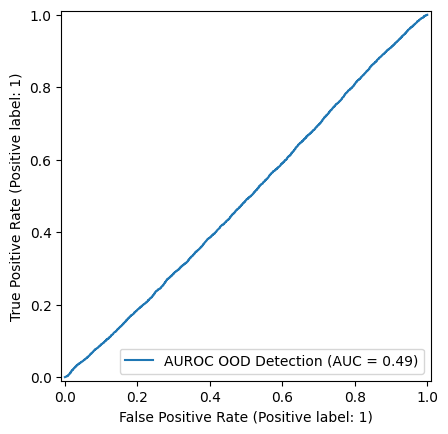

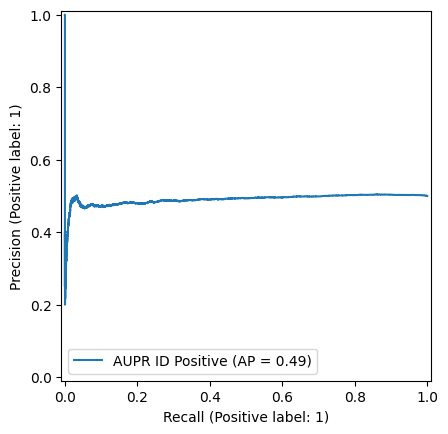

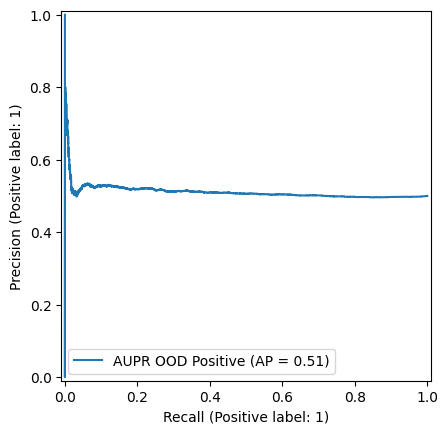

In [46]:
all_preds = stack_preds(model_gen, id_dl_test, ood_dl_test, device=device)

roc_pr_curve(all_preds)

Exactly like the for ODIN there is no appreciable gain in using JARN, this could be caused by the model, maybe it is too much of a toy (I make the most simple CNN possible) so maybe there is no 'space' for improvement, another cause maybe the training which could be improved in various ways (taking into account different settings like a higher number of epochs or a different learning rate). 

For JARN a different structure for the Discriminator, being an adversarial problem the balance between the learning of the generator and the discriminator is not easy to reach.